In [1]:
!which python

/home/mskang/.conda/envs/yeonung/bin/python


In [2]:
import os
import gym
import copy
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import deque
from skimage.color import rgb2gray
from skimage.transform import resize

In [3]:
gpu = torch.device('cuda:1')
torch.cuda.device_count()

2

In [4]:
env = gym.make('BreakoutDeterministic-v4')

In [5]:
# hyperparameters
MINIBATCH_SIZE = 64
HISTORY_SIZE = 4
TRAIN_START = 50000
FINAL_EXPLORATION = 0.2
TARGET_UPDATE = 10000
MEMORY_SIZE = 400000
EXPLORATION = 1000000
START_EXPLORATION = 1.
INPUT = env.observation_space.shape  # (210, 160, 3)
OUTPUT = env.action_space.n  # 4
HEIGHT = 84
WIDTH = 84
LEARNING_RATE = 0.00025
DISCOUNT = 0.99
EPSILON = 0.01
MOMENTUM = 0.95

In [6]:
def cliped_error(error):
    '''후버로스를 사용하여 error 클립.
    Args:
        error(tensor): 클립을 해야할 tensor
    Returns:
        tensor: -1 ~ 1 사이로 클립된 error
    '''
    return torch.where(torch.abs(error) < 1.0, 0.5 * torch.mul(error, error), torch.abs(error) - 0.5)

In [7]:
def pre_proc(X):
    '''입력데이터 전처리.
    Args:
        X(np.array): 받아온 이미지를 그레이 스케일링 후 84X84로 크기변경
            그리고 정수값으로 저장하기위해(메모리 효율 높이기 위해) 255를 곱함
    Returns:
        np.array: 변경된 이미지
    '''
    # 바로 전 frame과 비교하여 max를 취함으로써 flickering을 제거
    # x = np.maximum(X, X1)
    # 그레이 스케일링과 리사이징을 하여 데이터 크기 수정
    x = np.uint8(resize(rgb2gray(X), (HEIGHT, WIDTH), mode='reflect') * 255)
    return x

In [8]:
def get_copy_var_ops(*, dest_scope_name="target", src_scope_name="main"):
    '''타겟네트워크에 메인네트워크의 Weight값을 복사.
    Args:
        dest_scope_name="target"(DQN): 'target'이라는 이름을 가진 객체를 가져옴
        src_scope_name="main"(DQN): 'main'이라는 이름을 가진 객체를 가져옴
    Returns:
        list: main의 trainable한 값들이 target의 값으로 복사된 값
    '''
    op_holder = []

#     src_vars = tf.get_collection(
#         tf.GraphKeys.TRAINABLE_VARIABLES, scope=src_scope_name)
#     dest_vars = tf.get_collection(
#         tf.GraphKeys.TRAINABLE_VARIABLES, scope=dest_scope_name)

    for src_var, dest_var in zip(src_vars, dest_vars):
        op_holder.append(dest_var.assign(src_var.value()))

    return op_holder

In [9]:
def get_init_state(history, s):
    '''에피소드 시작 State를 초기화.
    Args:
        history(np.array): 5개의 프레임이 저장될 array
        s(list): 초기화된 이미지
    Note:
        history[:,:,:3]에 모두 초기화된 이미지(s)를 넣어줌
    '''
    for i in range(HISTORY_SIZE):
        history[:, :, i] = pre_proc(s)

In [10]:
def get_game_type(count, l, no_life_game, start_live):
    '''라이프가 있는 게임인지 판별
    Args:
        count(int): 에피소드 시작 후 첫 프레임인지 확인하기 위한 arg
        l(dict): 라이프 값들이 저장되어있는 dict ex) l['ale.lives']
        no_life_game(bool): 라이프가 있는 게임일 경우, bool 값을 반환해주기 위한 arg
        start_live(int): 라이프가 있는 경우 라이프값을 초기화 하기 위한 arg
    Returns:
        list:
            no_life_game(bool): 라이프가 없는 게임이면 True, 있으면 False
            start_live(int): 라이프가 있는 게임이면 초기화된 라이프
    '''
    if count == 1:
        start_live = l['ale.lives']
        # 시작 라이프가 0일 경우, 라이프 없는 게임
        if start_live == 0:
            no_life_game = True
        else:
            no_life_game = False
    return [no_life_game, start_live]

In [11]:
def get_terminal(start_live, l, reward, no_life_game, ter):
    '''목숨이 줄어들거나, negative reward를 받았을 때, terminal 처리
    Args:
        start_live(int): 라이프가 있는 게임일 경우, 현재 라이프 수
        l(dict): 다음 상태에서 라이프가 줄었는지 확인하기 위한 다음 frame의 라이프 info
        no_life_game(bool): 라이프가 없는 게임일 경우, negative reward를 받으면 terminal 처리를 해주기 위한 게임 타입
        ter(bool): terminal 처리를 저장할 arg
    Returns:
        list:
            ter(bool): terminal 상태
            start_live(int): 줄어든 라이프로 업데이트된 값
    '''
    if no_life_game:
        # 목숨이 없는 게임일 경우 Terminal 처리
        if reward < 0:
            ter = True
    else:
        # 목숨 있는 게임일 경우 Terminal 처리
        if start_live > l['ale.lives']:
            ter = True
            start_live = l['ale.lives']

    return [ter, start_live]

In [12]:
def train_minibatch(mainDQN, targetDQN, minibatch, optimizer):
    '''미니배치로 가져온 sample데이터로 메인네트워크 학습
    Args:
        mainDQN(object): 메인 네트워크
        targetDQN(object): 타겟 네트워크
        minibatch: replay_memory에서 MINIBATCH 개수만큼 랜덤 sampling 해온 값
    Note:
        replay_memory에서 꺼내온 값으로 메인 네트워크를 학습
    '''
    s_stack = []
    a_stack = []
    r_stack = []
    s1_stack = []
    d_stack = []

    for s_r, a_r, r_r, d_r in minibatch:
        s_stack.append(s_r[:, :, :4])
        a_stack.append(a_r)
        r_stack.append(r_r)
        s1_stack.append(s_r[:, :, 1:])
        d_stack.append(d_r)

    # True, False 값을 1과 0으로 변환
    d_stack = np.array(d_stack) + 0  # terminal이면 1, 아니면 0
    
    r_stack = np.array(r_stack)
    
    s1_stack = np.array(s1_stack).transpose((0, 3, 1, 2)) / 255.  # (minibatch, 84, 84, 4) -> (minibatch, 4, 84, 84)
    s1_stack = torch.tensor(s1_stack, device=gpu).float()

    Q1 = targetDQN(s1_stack)
    
    y = r_stack + (1 - d_stack) * DISCOUNT * Q1.cpu().detach().numpy().max(axis=1)

    s_stack = np.array(s_stack).transpose((0, 3, 1, 2)) / 255.  # (minibatch, 84, 84, 4) -> (minibatch, 4, 84, 84)
    s_stack = torch.tensor(s_stack, device=gpu).float()
    
    Q = mainDQN(s_stack)  # 현재 q val

    q_val = torch.max(Q, 1)
    
    y = torch.tensor(y, device=gpu).float()
    error = cliped_error(y - q_val[0])
    loss = torch.mean(error)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [13]:
# 데이터 플롯
def plot_data(epoch, epoch_score, average_reward, epoch_Q, average_Q):
    plt.clf()
    epoch_score.append(np.mean(average_reward))
    epoch_Q.append(np.mean(average_Q))

    plt.subplot(211)
    plt.axis([0, epoch, 0, np.max(epoch_Q) * 6 / 5])
    plt.xlabel('Training Epochs')
    plt.ylabel('Average Action Value(Q)')
    plt.plot(epoch_Q)

    plt.subplot(212)
    plt.axis([0, epoch, 0, np.max(epoch_score) * 6 / 5])
    plt.xlabel('Training Epochs')
    plt.ylabel('Average Reward per Episode')
    plt.plot(epoch_score, "r")
    plt.savefig("graph/{}epoch.png".format(epoch - 1))

In [14]:
class DQN(torch.nn.Module):
    def __init__(self, in_channels, OUTPUT):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, 4, 2)
        self.conv3 = nn.Conv2d(64, 64, 3, 1)
        self.fc1 = nn.Linear(7*7*64, 512)
        self.fc2 = nn.Linear(512, OUTPUT)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.fc1(x.reshape(-1, 7*7*64)))
        x = self.fc2(x)
        return x

In [15]:
DQN(4, OUTPUT)

DQN(
  (conv1): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
  (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=3136, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=4, bias=True)
)

In [16]:
def get_action(q, e):
    if e > np.random.rand(1):
        action = np.random.randint(OUTPUT)
    else:
        action = np.argmax(q)
    return action

In [17]:
def main():
    optimizer = torch.optim.RMSprop(mainDQN.parameters(), lr=LEARNING_RATE, eps=EPSILON, momentum=MOMENTUM)

    if os.path.exists('checkpoint.tar'):
        checkpoint = torch.load('checkpoint.tar')
        
        mainDQN = DQN(HISTORY_SIZE, OUTPUT)
        mainDQN = mainDQN.load_state_dict(checkpoint['model_state_dict'])
        
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

        e = checkpoint['e']
        episode, epoch, frame = checkpoint['episode'], checkpoint['epoch'], checkpoint['frame']
    else:
        mainDQN = DQN(HISTORY_SIZE, OUTPUT).to(gpu)
        
        e = 1.
        episode, epoch, frame = 0, 0, 0
        
    targetDQN = copy.deepcopy(mainDQN)

    recent_rlist = deque(maxlen=100)
    epoch_score, epoch_Q = deque(), deque()
    average_Q, average_reward = deque(), deque()

    epoch_on = False
    no_life_game = False
    replay_memory = deque(maxlen=MEMORY_SIZE)

    # Train agent during 200 epoch
    while epoch <= 200:
        episode += 1

        history = np.zeros([84, 84, 5], dtype=np.uint8)
        rall, count = 0, 0
        d = False
        start_lives = 0
        s = env.reset()

        get_init_state(history, s)  # history[0 ~ 3] = pre_proc(s)

        while not d:  # until episode ends
            # env.render()

            frame += 1  # frame counts in all episodes
            count += 1  # frame counts in an episode

            # e-greedy
            if e > FINAL_EXPLORATION and frame > TRAIN_START:
                e -= (START_EXPLORATION - FINAL_EXPLORATION) / EXPLORATION  # e = 1 - 0.0000009

            # 히스토리의 0~3 부분으로 Q값 예측
            X = history[:, :, :4].transpose(2, 0, 1).reshape(-1, 4, 84, 84) / 255.
            X = torch.tensor(X, device=gpu).float()
            Q = mainDQN(X)
            Q = Q.reshape(-1).cpu().detach().numpy()
            average_Q.append(np.max(Q))

            # 액션 선택
            action = get_action(Q, e)

            # 액션 개수 줄임(for Breakout)
            '''
            if action == 0:
                real_a = 1
            elif action == 1:
                real_a = 4
            else:
                real_a = 5
            '''

            # s1 : next frame / r : reward / d : done(terminal) / l : info(lives)
            s1, r, d, l = env.step(action)
            ter = d
            reward = np.clip(r, -1, 1)

            # 라이프가 있는 게임이면 no_life_game=True
            no_life_game, start_lives = get_game_type(count, l, no_life_game, start_lives)

            # 라이프가 줄어들거나 negative 리워드를 받았을 때 terminal 처리를 해줌
            ter, start_lives = get_terminal(start_lives, l, reward, no_life_game, ter)

            # 새로운 프레임을 히스토리 마지막에 넣어줌
            history[:, :, 4] = pre_proc(s1)

            # 메모리 저장 효율을 높이기 위해 5개의 프레임을 가진 히스토리를 저장
            # state와 next_state는 3개의 데이터가 겹침을 이용.
            replay_memory.append((np.copy(history[:, :, :]), action, reward, ter))
            history[:, :, :4] = history[:, :, 1:]

            rall += r

            if frame > 10000 and frame % MINIBATCH_SIZE == 0:  # frame > 50000
                # 프레임 스킵때마다 학습
                minibatch = random.sample(replay_memory, MINIBATCH_SIZE)
                train_minibatch(mainDQN, targetDQN, minibatch, optimizer)
                
                # 1만 프레임일때마다 target_net 업데이트
                if frame % TARGET_UPDATE == 0:
                    targetDQN = copy.deepcopy(mainDQN)
                    print('targetDQN updated')

            # 1 epoch(trained 50000 frame)마다 plot
            if (frame - TRAIN_START) % 50000 == 0:
                epoch_on = True

        recent_rlist.append(rall)  # 최근 100개 reward

        average_reward.append(rall)  # 한 epoch의 모든 reward

        if episode % 50 == 0:
            print("Episode:{0:6d} | Frames:{1:9d} | Steps:{2:5d} | Reward:{3:3.0f} | e-greedy:{4:.5f} | "
                  "Avg_Max_Q:{5:2.5f} | Recent reward:{6:.5f}  ".format(episode, frame, count, rall, e,
                                                                        np.mean(average_Q),
                                                                        np.mean(recent_rlist)))

        if epoch_on:
            epoch += 1
            plot_data(epoch, epoch_score, average_reward, epoch_Q, average_Q)
            epoch_on = False
            average_reward = deque()
            average_Q = deque()
            
            # Model checkpoint
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'e': e,
                'episode': episode,
                'epoch': epoch,
                'frame': frame
            }, 'checkpoint.tar')

Episode:    50 | Frames:     8348 | Steps:  165 | Reward:  1 | e-greedy:1.00000 | Avg_Max_Q:0.01522 | Recent reward:0.82000  
Episode:   100 | Frames:    17317 | Steps:  137 | Reward:  0 | e-greedy:1.00000 | Avg_Max_Q:0.01730 | Recent reward:1.01000  
Episode:   150 | Frames:    26549 | Steps:  234 | Reward:  2 | e-greedy:1.00000 | Avg_Max_Q:0.01856 | Recent reward:1.23000  
Episode:   200 | Frames:    35588 | Steps:  203 | Reward:  2 | e-greedy:1.00000 | Avg_Max_Q:0.01892 | Recent reward:1.21000  
targetDQN updated
Episode:   250 | Frames:    43606 | Steps:  139 | Reward:  0 | e-greedy:1.00000 | Avg_Max_Q:0.01961 | Recent reward:0.92000  


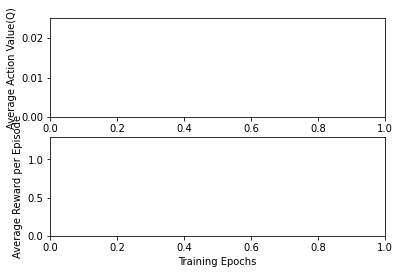

Episode:   300 | Frames:    52628 | Steps:  149 | Reward:  0 | e-greedy:0.99763 | Avg_Max_Q:0.02692 | Recent reward:0.93000  
Episode:   350 | Frames:    61596 | Steps:  209 | Reward:  2 | e-greedy:0.98956 | Avg_Max_Q:0.02683 | Recent reward:1.16000  
Episode:   400 | Frames:    70659 | Steps:  134 | Reward:  0 | e-greedy:0.98141 | Avg_Max_Q:0.02758 | Recent reward:1.16000  
Episode:   450 | Frames:    79831 | Steps:  140 | Reward:  0 | e-greedy:0.97315 | Avg_Max_Q:0.02826 | Recent reward:1.21000  
targetDQN updated
Episode:   500 | Frames:    89763 | Steps:  134 | Reward:  0 | e-greedy:0.96421 | Avg_Max_Q:0.02888 | Recent reward:1.42000  
Episode:   550 | Frames:    99162 | Steps:  134 | Reward:  0 | e-greedy:0.95575 | Avg_Max_Q:0.02926 | Recent reward:1.47000  


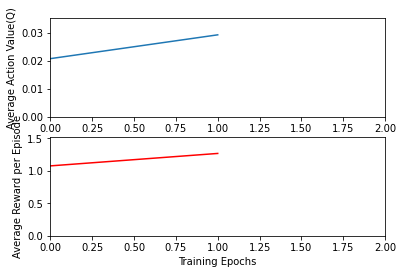

Episode:   600 | Frames:   108269 | Steps:  156 | Reward:  1 | e-greedy:0.94756 | Avg_Max_Q:0.03405 | Recent reward:1.35000  
Episode:   650 | Frames:   117759 | Steps:  161 | Reward:  1 | e-greedy:0.93902 | Avg_Max_Q:0.03311 | Recent reward:1.41000  
targetDQN updated
Episode:   700 | Frames:   126691 | Steps:  185 | Reward:  2 | e-greedy:0.93098 | Avg_Max_Q:0.03334 | Recent reward:1.31000  
Episode:   750 | Frames:   136339 | Steps:  168 | Reward:  1 | e-greedy:0.92229 | Avg_Max_Q:0.03442 | Recent reward:1.38000  
Episode:   800 | Frames:   145913 | Steps:  216 | Reward:  2 | e-greedy:0.91368 | Avg_Max_Q:0.03484 | Recent reward:1.55000  


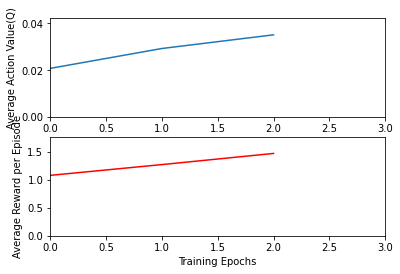

Episode:   850 | Frames:   155728 | Steps:  206 | Reward:  2 | e-greedy:0.90484 | Avg_Max_Q:0.03791 | Recent reward:1.61000  
targetDQN updated
Episode:   900 | Frames:   166528 | Steps:  309 | Reward:  4 | e-greedy:0.89512 | Avg_Max_Q:0.04102 | Recent reward:1.96000  
Episode:   950 | Frames:   176044 | Steps:  315 | Reward:  5 | e-greedy:0.88656 | Avg_Max_Q:0.04312 | Recent reward:1.85000  
Episode:  1000 | Frames:   186422 | Steps:  223 | Reward:  3 | e-greedy:0.87722 | Avg_Max_Q:0.04461 | Recent reward:1.72000  
Episode:  1050 | Frames:   197542 | Steps:  343 | Reward:  9 | e-greedy:0.86721 | Avg_Max_Q:0.04555 | Recent reward:2.13000  
targetDQN updated


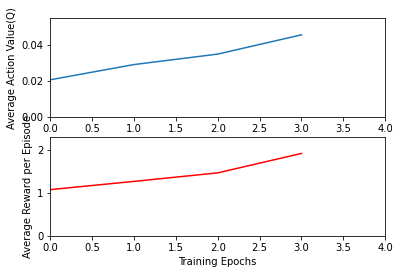

Episode:  1100 | Frames:   208968 | Steps:  179 | Reward:  1 | e-greedy:0.85693 | Avg_Max_Q:0.05815 | Recent reward:2.44000  
Episode:  1150 | Frames:   220196 | Steps:  244 | Reward:  3 | e-greedy:0.84682 | Avg_Max_Q:0.05801 | Recent reward:2.59000  
Episode:  1200 | Frames:   230951 | Steps:  133 | Reward:  0 | e-greedy:0.83714 | Avg_Max_Q:0.05784 | Recent reward:2.42000  
targetDQN updated
Episode:  1250 | Frames:   242793 | Steps:  203 | Reward:  2 | e-greedy:0.82649 | Avg_Max_Q:0.05819 | Recent reward:2.62000  


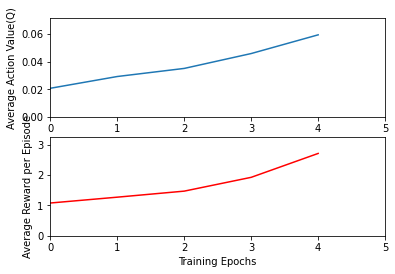

Episode:  1300 | Frames:   254593 | Steps:  241 | Reward:  3 | e-greedy:0.81587 | Avg_Max_Q:0.06762 | Recent reward:2.95000  
Episode:  1350 | Frames:   266948 | Steps:  335 | Reward:  5 | e-greedy:0.80475 | Avg_Max_Q:0.06680 | Recent reward:3.11000  
Episode:  1400 | Frames:   279330 | Steps:  279 | Reward:  4 | e-greedy:0.79360 | Avg_Max_Q:0.06645 | Recent reward:3.28000  
targetDQN updated
Episode:  1450 | Frames:   292916 | Steps:  382 | Reward:  6 | e-greedy:0.78138 | Avg_Max_Q:0.06504 | Recent reward:3.68000  


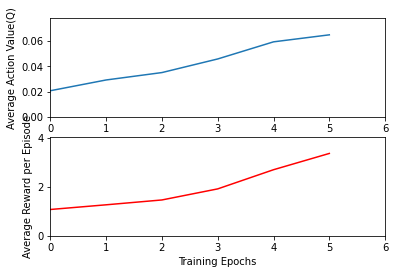

Episode:  1500 | Frames:   304939 | Steps:  188 | Reward:  2 | e-greedy:0.77055 | Avg_Max_Q:0.06336 | Recent reward:3.75000  
Episode:  1550 | Frames:   317101 | Steps:  327 | Reward:  5 | e-greedy:0.75961 | Avg_Max_Q:0.06268 | Recent reward:3.41000  
targetDQN updated
Episode:  1600 | Frames:   330296 | Steps:  273 | Reward:  4 | e-greedy:0.74773 | Avg_Max_Q:0.06405 | Recent reward:3.52000  
Episode:  1650 | Frames:   343312 | Steps:  265 | Reward:  7 | e-greedy:0.73602 | Avg_Max_Q:0.06499 | Recent reward:3.82000  


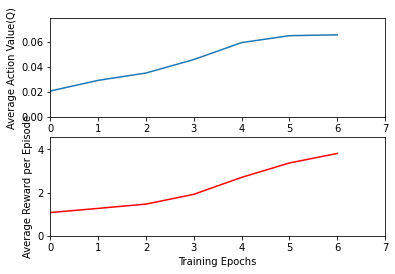

Episode:  1700 | Frames:   357567 | Steps:  224 | Reward:  3 | e-greedy:0.72319 | Avg_Max_Q:0.06865 | Recent reward:4.32000  
targetDQN updated
Episode:  1750 | Frames:   371151 | Steps:  327 | Reward:  5 | e-greedy:0.71096 | Avg_Max_Q:0.07105 | Recent reward:4.50000  
Episode:  1800 | Frames:   384653 | Steps:  221 | Reward:  2 | e-greedy:0.69881 | Avg_Max_Q:0.07120 | Recent reward:4.38000  
Episode:  1850 | Frames:   398347 | Steps:  256 | Reward:  7 | e-greedy:0.68649 | Avg_Max_Q:0.07138 | Recent reward:4.44000  
targetDQN updated


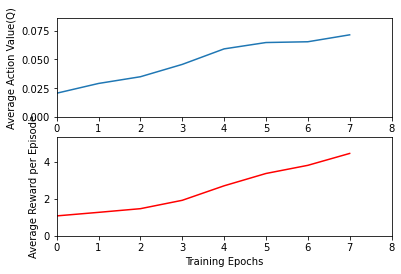

Episode:  1900 | Frames:   411858 | Steps:  160 | Reward:  1 | e-greedy:0.67433 | Avg_Max_Q:0.07034 | Recent reward:4.55000  
Episode:  1950 | Frames:   425980 | Steps:  355 | Reward:  5 | e-greedy:0.66162 | Avg_Max_Q:0.07236 | Recent reward:4.72000  
targetDQN updated
Episode:  2000 | Frames:   440018 | Steps:  284 | Reward:  8 | e-greedy:0.64898 | Avg_Max_Q:0.07302 | Recent reward:4.79000  


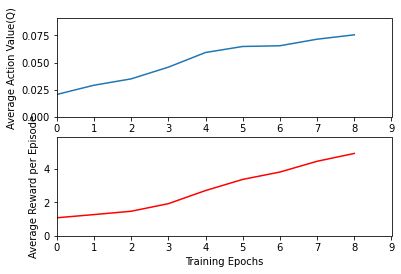

Episode:  2050 | Frames:   453922 | Steps:  385 | Reward:  9 | e-greedy:0.63647 | Avg_Max_Q:0.09104 | Recent reward:5.09000  
Episode:  2100 | Frames:   467936 | Steps:  198 | Reward:  2 | e-greedy:0.62386 | Avg_Max_Q:0.08580 | Recent reward:5.34000  
targetDQN updated
Episode:  2150 | Frames:   482211 | Steps:  202 | Reward:  2 | e-greedy:0.61101 | Avg_Max_Q:0.08593 | Recent reward:5.42000  
Episode:  2200 | Frames:   497427 | Steps:  406 | Reward:  7 | e-greedy:0.59732 | Avg_Max_Q:0.08554 | Recent reward:5.60000  


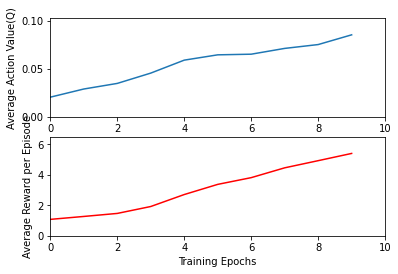

Episode:  2250 | Frames:   511435 | Steps:  275 | Reward:  4 | e-greedy:0.58471 | Avg_Max_Q:0.08519 | Recent reward:5.42000  
targetDQN updated
Episode:  2300 | Frames:   526905 | Steps:  280 | Reward:  7 | e-greedy:0.57079 | Avg_Max_Q:0.08952 | Recent reward:5.81000  
Episode:  2350 | Frames:   541482 | Steps:  363 | Reward:  9 | e-greedy:0.55767 | Avg_Max_Q:0.09473 | Recent reward:5.97000  


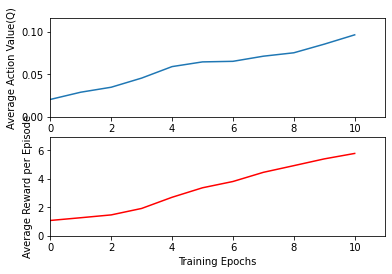

Episode:  2400 | Frames:   556471 | Steps:  261 | Reward:  3 | e-greedy:0.54418 | Avg_Max_Q:0.10166 | Recent reward:5.74000  
targetDQN updated
Episode:  2450 | Frames:   572060 | Steps:  260 | Reward:  7 | e-greedy:0.53015 | Avg_Max_Q:0.11334 | Recent reward:6.17000  
Episode:  2500 | Frames:   587508 | Steps:  244 | Reward:  3 | e-greedy:0.51624 | Avg_Max_Q:0.11744 | Recent reward:6.37000  
targetDQN updated


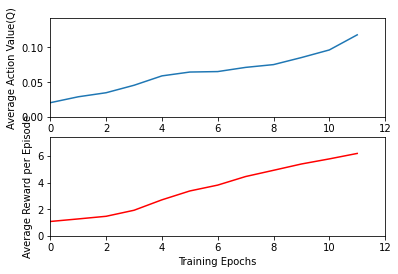

Episode:  2550 | Frames:   602751 | Steps:  278 | Reward:  7 | e-greedy:0.50252 | Avg_Max_Q:0.13253 | Recent reward:6.12000  
Episode:  2600 | Frames:   618544 | Steps:  224 | Reward:  3 | e-greedy:0.48831 | Avg_Max_Q:0.13160 | Recent reward:6.47000  
Episode:  2650 | Frames:   634576 | Steps:  231 | Reward:  3 | e-greedy:0.47388 | Avg_Max_Q:0.13131 | Recent reward:7.39000  
targetDQN updated
Episode:  2700 | Frames:   649822 | Steps:  224 | Reward:  3 | e-greedy:0.46016 | Avg_Max_Q:0.13428 | Recent reward:7.43000  


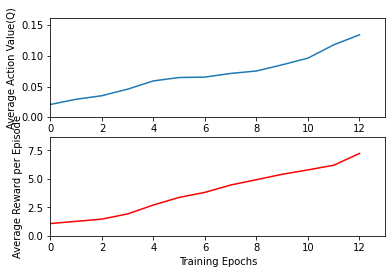

Episode:  2750 | Frames:   664866 | Steps:  418 | Reward:  7 | e-greedy:0.44662 | Avg_Max_Q:0.14623 | Recent reward:6.95000  
targetDQN updated
Episode:  2800 | Frames:   680567 | Steps:  281 | Reward:  7 | e-greedy:0.43249 | Avg_Max_Q:0.14700 | Recent reward:7.02000  
Episode:  2850 | Frames:   696259 | Steps:  332 | Reward: 11 | e-greedy:0.41837 | Avg_Max_Q:0.15019 | Recent reward:7.33000  


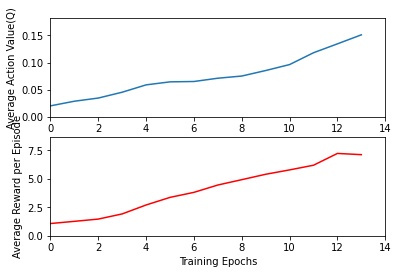

Episode:  2900 | Frames:   712246 | Steps:  297 | Reward:  4 | e-greedy:0.40398 | Avg_Max_Q:0.15760 | Recent reward:7.46000  
targetDQN updated
Episode:  2950 | Frames:   729233 | Steps:  275 | Reward:  4 | e-greedy:0.38869 | Avg_Max_Q:0.16515 | Recent reward:7.67000  
Episode:  3000 | Frames:   745397 | Steps:  298 | Reward:  4 | e-greedy:0.37414 | Avg_Max_Q:0.17042 | Recent reward:7.78000  


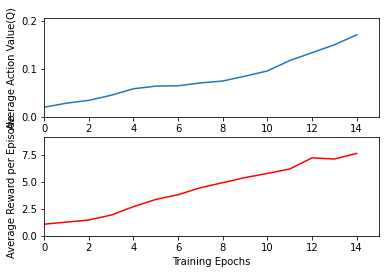

targetDQN updated
Episode:  3050 | Frames:   761603 | Steps:  297 | Reward: 11 | e-greedy:0.35956 | Avg_Max_Q:0.18043 | Recent reward:7.44000  
Episode:  3100 | Frames:   778051 | Steps:  293 | Reward:  8 | e-greedy:0.34475 | Avg_Max_Q:0.18598 | Recent reward:7.52000  
Episode:  3150 | Frames:   793903 | Steps:  258 | Reward:  3 | e-greedy:0.33049 | Avg_Max_Q:0.18728 | Recent reward:8.08000  
targetDQN updated


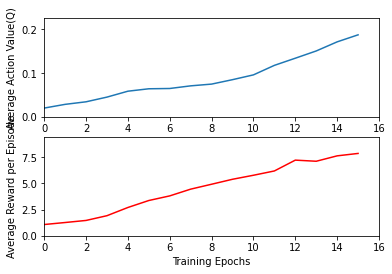

Episode:  3200 | Frames:   810013 | Steps:  280 | Reward:  7 | e-greedy:0.31599 | Avg_Max_Q:0.20265 | Recent reward:7.89000  
Episode:  3250 | Frames:   827752 | Steps:  414 | Reward:  9 | e-greedy:0.30002 | Avg_Max_Q:0.20080 | Recent reward:8.01000  
targetDQN updated
Episode:  3300 | Frames:   843727 | Steps:  341 | Reward: 11 | e-greedy:0.28565 | Avg_Max_Q:0.20145 | Recent reward:8.21000  


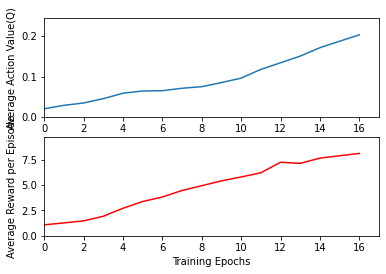

Episode:  3350 | Frames:   860660 | Steps:  291 | Reward: 11 | e-greedy:0.27041 | Avg_Max_Q:0.21366 | Recent reward:8.31000  
Episode:  3400 | Frames:   877803 | Steps:  301 | Reward: 11 | e-greedy:0.25498 | Avg_Max_Q:0.21347 | Recent reward:8.90000  
targetDQN updated
Episode:  3450 | Frames:   894528 | Steps:  377 | Reward:  9 | e-greedy:0.23992 | Avg_Max_Q:0.21969 | Recent reward:8.95000  


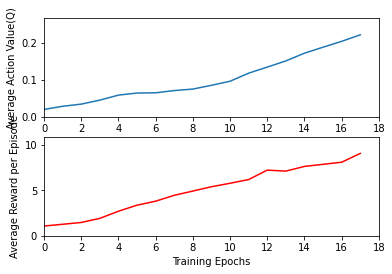

Episode:  3500 | Frames:   913346 | Steps:  330 | Reward: 11 | e-greedy:0.22299 | Avg_Max_Q:0.23076 | Recent reward:9.20000  
targetDQN updated
Episode:  3550 | Frames:   931592 | Steps:  330 | Reward: 11 | e-greedy:0.20657 | Avg_Max_Q:0.23551 | Recent reward:9.44000  


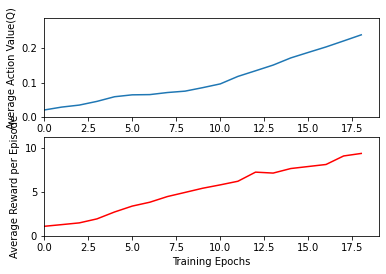

Episode:  3600 | Frames:   950599 | Steps:  300 | Reward:  7 | e-greedy:0.18946 | Avg_Max_Q:0.26148 | Recent reward:9.37000  
targetDQN updated
Episode:  3650 | Frames:   968970 | Steps:  401 | Reward:  9 | e-greedy:0.17293 | Avg_Max_Q:0.25123 | Recent reward:9.36000  
Episode:  3700 | Frames:   986862 | Steps:  284 | Reward:  4 | e-greedy:0.15682 | Avg_Max_Q:0.25161 | Recent reward:8.73000  
targetDQN updated


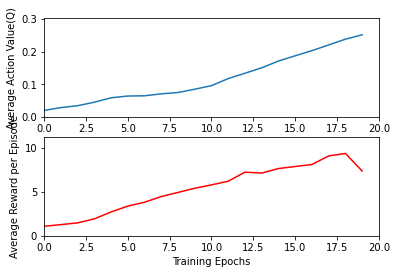

Episode:  3750 | Frames:  1003828 | Steps:  365 | Reward:  2 | e-greedy:0.14155 | Avg_Max_Q:0.25773 | Recent reward:6.02000  
Episode:  3800 | Frames:  1021521 | Steps:  417 | Reward:  7 | e-greedy:0.12563 | Avg_Max_Q:0.25895 | Recent reward:4.07000  
Episode:  3850 | Frames:  1039165 | Steps:  377 | Reward:  2 | e-greedy:0.10975 | Avg_Max_Q:0.25851 | Recent reward:3.83000  
targetDQN updated


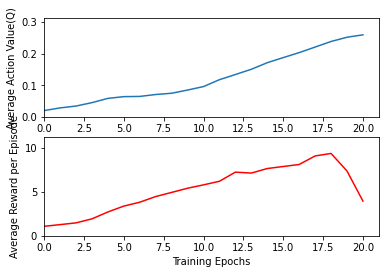

Episode:  3900 | Frames:  1058335 | Steps:  622 | Reward:  3 | e-greedy:0.10000 | Avg_Max_Q:0.25910 | Recent reward:3.58000  
Episode:  3950 | Frames:  1077533 | Steps:  438 | Reward:  7 | e-greedy:0.10000 | Avg_Max_Q:0.25673 | Recent reward:3.35000  
targetDQN updated
Episode:  4000 | Frames:  1097074 | Steps:  492 | Reward:  1 | e-greedy:0.10000 | Avg_Max_Q:0.25466 | Recent reward:3.20000  


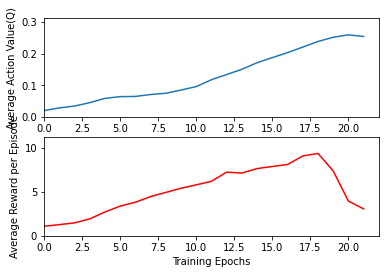

Episode:  4050 | Frames:  1116047 | Steps:  461 | Reward:  2 | e-greedy:0.10000 | Avg_Max_Q:0.25366 | Recent reward:3.13000  
targetDQN updated
Episode:  4100 | Frames:  1135002 | Steps:  297 | Reward:  1 | e-greedy:0.10000 | Avg_Max_Q:0.25374 | Recent reward:2.71000  


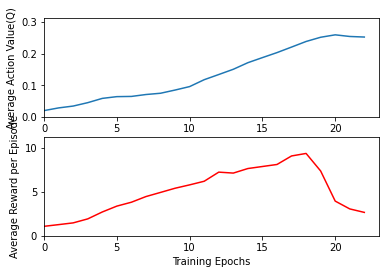

Episode:  4150 | Frames:  1155411 | Steps:  401 | Reward:  1 | e-greedy:0.10000 | Avg_Max_Q:0.24861 | Recent reward:2.55000  
targetDQN updated
Episode:  4200 | Frames:  1174266 | Steps:  522 | Reward:  1 | e-greedy:0.10000 | Avg_Max_Q:0.25114 | Recent reward:2.57000  
Episode:  4250 | Frames:  1192739 | Steps:  311 | Reward:  2 | e-greedy:0.10000 | Avg_Max_Q:0.25505 | Recent reward:2.77000  
targetDQN updated


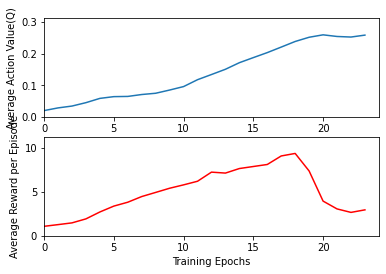

Episode:  4300 | Frames:  1212345 | Steps:  561 | Reward:  1 | e-greedy:0.10000 | Avg_Max_Q:0.25448 | Recent reward:3.17000  
Episode:  4350 | Frames:  1231289 | Steps:  446 | Reward:  3 | e-greedy:0.10000 | Avg_Max_Q:0.25652 | Recent reward:3.20000  
targetDQN updated


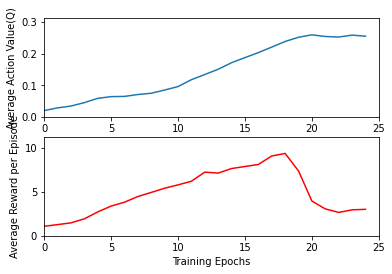

Episode:  4400 | Frames:  1251846 | Steps:  429 | Reward:  1 | e-greedy:0.10000 | Avg_Max_Q:0.26008 | Recent reward:3.01000  
Episode:  4450 | Frames:  1270555 | Steps:  372 | Reward:  7 | e-greedy:0.10000 | Avg_Max_Q:0.24514 | Recent reward:2.70000  


KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

In [18]:
main()